<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/mkkim/Restaurant_Visitor_Forecasting_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/Data/recruit-restaurant-visitor-forecasting.zip /content/

In [3]:
!unzip -qq /content/recruit-restaurant-visitor-forecasting.zip

In [137]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
import datetime
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 
import scipy as sp
from sklearn.preprocessing import StandardScaler #Analysis 
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate

In [138]:
data_path = '../content/'
air_reserve = pd.read_csv(data_path + 'air_reserve.csv.zip').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv.zip').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv.zip').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv.zip').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv.zip').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv.zip').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv.zip').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv.zip')

In [139]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])

lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

# 시각화

In [140]:
data.tail()

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
284122,air_fff68b929994bfbd,2017-05-27,0.0,air_fff68b929994bfbd_2017-05-27,5,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,0,1
284123,air_fff68b929994bfbd,2017-05-28,0.0,air_fff68b929994bfbd_2017-05-28,6,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,0,1
284124,air_fff68b929994bfbd,2017-05-29,0.0,air_fff68b929994bfbd_2017-05-29,0,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,0,0
284125,air_fff68b929994bfbd,2017-05-30,0.0,air_fff68b929994bfbd_2017-05-30,1,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,0,0
284126,air_fff68b929994bfbd,2017-05-31,0.0,air_fff68b929994bfbd_2017-05-31,2,1,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,7,0,0


##4.6

In [148]:
train_size = len(air_visit)
train = data[:train_size]
grouped = data['visitors'].groupby(data['holiday_flg'])

a=grouped.sum().reset_index()
df=pd.DataFrame(a)
df.head()

,holiday_flg,visitors
0,0,669516.008116
1,1,37089.341711


[Text(0, 0, 'True'), Text(0, 0, 'False')]

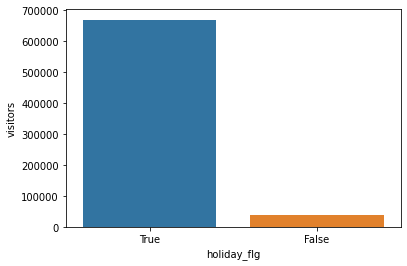

In [153]:
train_size = len(air_visit)
train = data[:train_size]
df=train['visitors'].groupby(train['holiday_flg']).sum().reset_index()
ax=sns.barplot(x='holiday_flg', y='visitors', data=df)
ax.set_xticklabels(['True','False'], fontsize=10)


In [68]:
train['visitors']

0         3.258097
1         3.496508
2         3.401197
3         3.135494
4         1.945910
            ...   
252103    1.945910
252104    1.945910
252105    2.079442
252106    2.197225
252107    1.791759
Name: visitors, Length: 252108, dtype: float64

In [60]:
df1.head()

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
0,air_ba937bf13d40fb24,2016-01-13,3.258097,air_ba937bf13d40fb24_2016-01-13,2.0,4.0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,0.0,0.0
1,air_ba937bf13d40fb24,2016-01-14,3.496508,air_ba937bf13d40fb24_2016-01-14,3.0,4.0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,0.0,0.0
2,air_ba937bf13d40fb24,2016-01-15,3.401197,air_ba937bf13d40fb24_2016-01-15,4.0,4.0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,0.0,0.0
3,air_ba937bf13d40fb24,2016-01-16,3.135494,air_ba937bf13d40fb24_2016-01-16,5.0,4.0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,0.0,1.0
4,air_ba937bf13d40fb24,2016-01-18,1.945910,air_ba937bf13d40fb24_2016-01-18,0.0,4.0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,0.0,0.0


In [84]:
df=pd.to_datetime(train['visit_date'])
df

0        2016-01-13
1        2016-01-14
2        2016-01-15
3        2016-01-16
4        2016-01-18
            ...    
252103   2017-04-18
252104   2017-04-19
252105   2017-04-20
252106   2017-04-21
252107   2017-04-22
Name: visit_date, Length: 252108, dtype: datetime64[ns]

In [93]:
train['visit_date']

0         2016-01-13
1         2016-01-14
2         2016-01-15
3         2016-01-16
4         2016-01-18
             ...    
252103    2017-04-18
252104    2017-04-19
252105    2017-04-20
252106    2017-04-21
252107    2017-04-22
Name: visit_date, Length: 252108, dtype: object

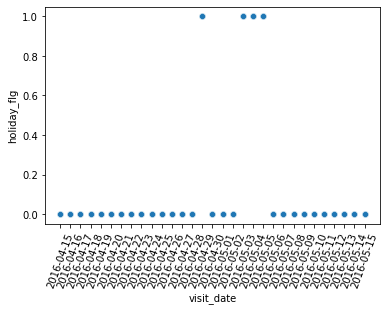

In [146]:
df=pd.to_datetime(data['visit_date'])
df1=(df>="2016-04-15") & (df<="2016-05-15")

df1=data[df1]
df1 = df1.sort_values(by='visit_date' ,ascending=True)
sns.scatterplot(x="visit_date", y="holiday_flg" ,data=df1)
p=plt.xticks(rotation = 'vertical')

degrees = 70
p=plt.xticks(rotation=degrees)


24662
                    store_id  visit_date  ...  holiday_flg holiday_flg2
284122  air_fff68b929994bfbd  2017-05-27  ...            0            1
284123  air_fff68b929994bfbd  2017-05-28  ...            0            1
284124  air_fff68b929994bfbd  2017-05-29  ...            0            0
284125  air_fff68b929994bfbd  2017-05-30  ...            0            0
284126  air_fff68b929994bfbd  2017-05-31  ...            0            0

[5 rows x 12 columns]


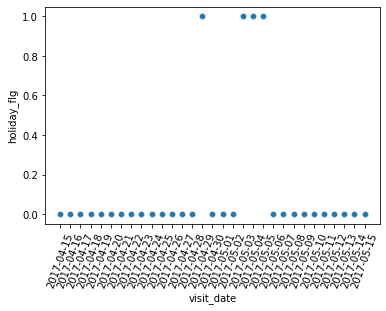

In [147]:
df=pd.to_datetime(data['visit_date'])
df2=(df>="2017-04-15") & (df<="2017-05-15")

df2=data[df2]

sns.scatterplot(x="visit_date", y="holiday_flg"  ,data=df2)
p=plt.xticks(rotation = 'vertical')

degrees = 70
p=plt.xticks(rotation=degrees)

## 5.2

[Text(0, 0, 'True'), Text(0, 0, 'False')]

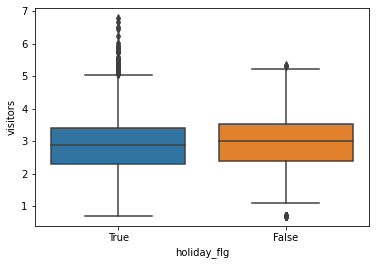

In [154]:
ax=sns.boxplot(x="holiday_flg", y="visitors",  data=train)
ax.set_xticklabels(['True','False'], fontsize=10)

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   store_id        252108 non-null  object 
 1   visit_date      252108 non-null  object 
 2   visitors        252108 non-null  float64
 3   id              252108 non-null  object 
 4   dow             252108 non-null  int64  
 5   air_genre_name  252108 non-null  int64  
 6   air_area_name   252108 non-null  object 
 7   latitude        252108 non-null  float64
 8   longitude       252108 non-null  float64
 9   air_area_name0  252108 non-null  int64  
 10  holiday_flg     252108 non-null  int64  
 11  holiday_flg2    252108 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 35.0+ MB


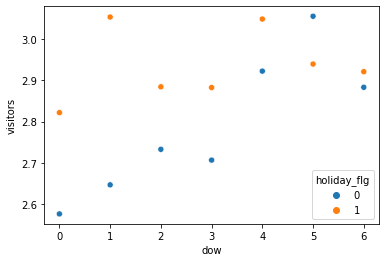

In [170]:



df=train.copy()
df1=train.groupby(['dow','holiday_flg'])['visitors'].mean().reset_index()
df1.head()
sns.scatterplot(x="dow", y="visitors", hue='holiday_flg' ,data=df1)
